In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import keras

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from keras import backend as K
!pip install keras-lookahead
!pip install texthero

import texthero as hero
from texthero import preprocessing


  Created wheel for keras-lookahead: filename=keras_lookahead-0.9.0-cp36-none-any.whl size=6406 sha256=e334b9f9569b063b511683eb6fee801ce7833cfed2790a7863e7158c91678f90
  Stored in directory: /root/.cache/pip/wheels/80/e1/a7/027d1227307b7425941fe5b1a896f8a8b9556b432a2c540a07
Successfully built keras-lookahead
     |████████████████████████████████| 1.4MB 14.1MB/s 
     |████████████████████████████████| 245kB 23.9MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434679 sha256=5155674affa0259680a0cb71a292cd4ed2cdfd7f7b93f610ffff4d51818aecb5
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
keras.__version__

'2.4.0'

In [6]:
cols = ['EventDescription','IncidentCause','IncidentConsequence', 'Category']

In [7]:
df2 = pd.read_csv('/content/drive/MyDrive/ESV Data/cleaned_incidents1.csv', usecols = cols)
df2.head()

,EventDescription,IncidentCause,IncidentConsequence,Category
0,A nearby customer reported sparking of electri...,HVABC cable faulted midspan,Grassfire,OH Cable
1,A contractor reported that he had contacted an...,Contractor contacted earthing conductor,No Go Zone (contact),Dug up
2,A field crew attending an outage found that a ...,Conductor broke due to rust,Serious risk to public safety (e.g. live condu...,Connection
3,Interfere and vandalism in substation. Unknown...,Vandalism,Loss of supply;Damage to network assets,Other
4,A nearby customer reported that a high load ha...,Unknown high load contacted LV service cable,No Go Zone (contact);Damage to network assets,Vehicle


In [8]:
df2['Category'].unique()

array(['OH Cable', 'Dug up', 'Connection', 'Other', 'Vehicle', 'Fuse',
       'Trees', 'Pole', 'Crossarm', 'Conductor', 'Animal', 'AF Other',
       'Lightning', 'UG Cable', nan, 'Installation'], dtype=object)

In [9]:
df2 = df2.dropna()
df2['Category'].unique()

array(['OH Cable', 'Dug up', 'Connection', 'Other', 'Vehicle', 'Fuse',
       'Trees', 'Pole', 'Crossarm', 'Conductor', 'Animal', 'AF Other',
       'Lightning', 'UG Cable', 'Installation'], dtype=object)

In [10]:
df2.shape
df2.isnull().sum()

EventDescription       0
IncidentCause          0
IncidentConsequence    0
Category               0
dtype: int64

In [11]:
df2['Description'] = df2['EventDescription'] + ' ' +  df2['IncidentCause']+ ' ' + df2['IncidentConsequence']

In [12]:
df2['Description']

0       A nearby customer reported sparking of electri...
1       A contractor reported that he had contacted an...
2       A field crew attending an outage found that a ...
3       Interfere and vandalism in substation. Unknown...
4       A nearby customer reported that a high load ha...
                              ...                        
6499    A report came in to UE of a FMB sparking at 31...
6500    Report received from a resident to advise that...
6501    Report received of pole fire at incident locat...
6502    A customer called to report a tractor had hit ...
6503    concrete electrical cover outside of front of ...
Name: Description, Length: 6488, dtype: object

In [13]:
#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   #, preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   #, preprocessing.remove_stopwords
                   , preprocessing.remove_whitespace]
                   #, preprocessing.stem]



#pass the custom_pipeline to the pipeline argument
df2['Description'] = hero.clean(df2['Description'], pipeline = custom_pipeline)
df2['Description']

0       a nearby customer reported sparking of electri...
1       a contractor reported that he had contacted an...
2       a field crew attending an outage found that a ...
3       interfere and vandalism in substation. unknown...
4       a nearby customer reported that a high load ha...
                              ...                        
6499    a report came in to ue of a fmb sparking at st...
6500    report received from a resident to advise that...
6501    report received of pole fire at incident locat...
6502    a customer called to report a tractor had hit ...
6503    concrete electrical cover outside of front of ...
Name: Description, Length: 6488, dtype: object

In [14]:
#Label encode the category
le = LabelEncoder()
df2['Category'] = le.fit_transform(df2['Category'].astype(str))
Y = df2['Category'] 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df2['Description'],Y, 
                                                    test_size=0.25, random_state=4, stratify = Y)

In [16]:
max_words = 1000*5
max_len = 100*1
tok = Tokenizer(num_words=max_words,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ",)
tok.fit_on_texts(df2['Description'])
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #X_train
print(sequences_matrix.shape)

(4866, 100)


In [17]:
sequences1 = tok.texts_to_sequences(x_test)
sequences_matrix1 = sequence.pad_sequences(sequences1,maxlen=max_len) #X_train
print(sequences_matrix1.shape)

(1622, 100)


In [18]:
units_mul = 200  #tensorflow experimentor
unique_categories = np.unique(Y)
print(unique_categories)
labels_count = len(unique_categories)
dropout = 0.2

def RNN3():
  model = tf.keras.Sequential()
  model.add(Embedding(max_words, units_mul, input_length=sequences_matrix.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(0.2))
  #model.add(layers.LSTM(units_mul, dropout=dropout, activation='tanh'))
  model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  #model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  model.add(layers.MaxPooling1D(pool_size=2))
  # todo try bidrectional layer again
  model.add(layers.LSTM(units_mul, dropout=dropout,recurrent_dropout=dropout, activation='tanh'))
  model.add(Dense(labels_count, activation='softmax'))
  return model

RNN3().summary()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 200)          1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 200)           120200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 15)                3015      
Total params: 1,444,015
Trainable params: 1,444,015
Non-trainable params: 0

In [19]:
from keras_lookahead import Lookahead
from keras.callbacks import LearningRateScheduler
optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
lk = Lookahead(optimiser, sync_period=5, slow_step=0.5, name = 'Lookahead')

#The step decay learning rate
#Step Decay A typical way is to to drop the learning rate by half every 10 epochs 
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    alpha = initAlpha *(factor **np.floor((1 + epoch)/dropEvery))
    return float(alpha)


# train model
model = RNN3()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=lk.optimizer,
              metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  history = model.fit(sequences_matrix,y_train, batch_size=128,
                    epochs=10, 
                    validation_split=0.2,
                    callbacks=[LearningRateScheduler(step_decay)])
  

#learning rate plateau


Epoch 1/10
31/31 [==============================] - 7s 213ms/step - loss: 1.5326 - accuracy: 0.5077 - val_loss: 1.0460 - val_accuracy: 0.6674
Epoch 2/10
31/31 [==============================] - 6s 197ms/step - loss: 0.7343 - accuracy: 0.7772 - val_loss: 0.8452 - val_accuracy: 0.7372
Epoch 3/10
31/31 [==============================] - 6s 197ms/step - loss: 0.4743 - accuracy: 0.8577 - val_loss: 0.7511 - val_accuracy: 0.7803
Epoch 4/10
31/31 [==============================] - 6s 200ms/step - loss: 0.3219 - accuracy: 0.8972 - val_loss: 0.8073 - val_accuracy: 0.7906
Epoch 5/10
31/31 [==============================] - 6s 198ms/step - loss: 0.1898 - accuracy: 0.9437 - val_loss: 0.7874 - val_accuracy: 0.7875
Epoch 6/10
31/31 [==============================] - 6s 202ms/step - loss: 0.1092 - accuracy: 0.9707 - val_loss: 0.8107 - val_accuracy: 0.8080
Epoch 7/10
31/31 [==============================] - 6s 204ms/step - loss: 0.0752 - accuracy: 0.9818 - val_loss: 0.8612 - val_accuracy: 0.7957
Epoch 

In [20]:
accr = model.evaluate(sequences_matrix1,y_test)
print(accr[1])

51/51 [==============================] - 1s 14ms/step - loss: 0.8401 - accuracy: 0.8095
0.8094944357872009


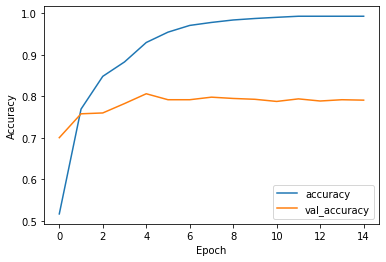

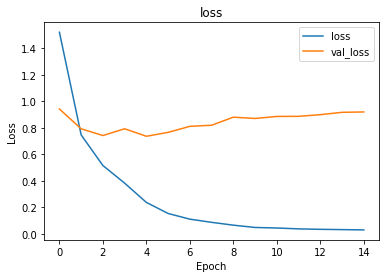

In [103]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [104]:
#Save the model.

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
with open("model_num.json", "w") as json_file:
  json_file.write('model_json')
model.save_weights('model_weights.h5')
